In [216]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import imaplib
import email
import os
import poplib
import getpass

import plotly
import plotly.plotly as py
from plotly import tools
from plotly.tools import FigureFactory as FF
import plotly.graph_objs as go
plotly.offline.init_notebook_mode(connected=True)

from os import listdir
from os.path import isfile, join

import math


pd.set_option('display.max_columns',1000)
pd.set_option('display.max_rows',1000)
 
    

In [217]:
#read from xl csv...
df = pd.read_excel('CaraHittahV2.xlsx', sheet_name=None, ignore_index = False, sort=True)
cdf = pd.concat(df.values())

In [218]:
#the CSV is a bit of a mess - we take first row as the header, and start from row 2
#cdf.head()
cdf.columns = cdf.iloc[1, :]
cdf = cdf.iloc[2:, :]

In [219]:
#drop some columns - interesting way to do it by subsetting columns

hx = cdf[[                 'AB',                'Date',            
         'Strike Zone Width',                  'BV',               'POI X',
              'Bat Material',     'Impact Momentum',        'Horiz. Angle',
                                         'Dist',             'P. Type',
        'Strike Zone Bottom',                 'Pts',                'Velo',
         'Vertical Distance',               'Pitch',                'User',
                     'POI Y',                 'Res',   'Trigger to Impact',
                         
                         'Horizontal Distance',     'Strike Zone Top',
                'Hand Speed',                  'LA',          'Time Stamp',
               'Strike Zone',                                  'POI Z',
                        'AA',                'Type',  'Pitch Angle', 
          'Batting', 'Level', 'Barrel'  ]]

hx['BPower'] = 0


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [264]:
#hx.sample(60)

In [362]:
hx = pd.read_csv("c:\\tmp\msgs\\hittraxemail.csv")
hx['BPower'] = 0

In [363]:
def removefloats(row):
    if type (row['User']) == float:
        return "dummy"
    else:
        return(row['User'])

In [364]:
def getXDist(row):
    theta = row['Horiz. Angle'] 
    theta = float(theta*(math.pi/180))
    d = float(row['Dist'])
    return (d*math.sin(theta))

In [365]:
def getYDist(row):
    theta = row['Horiz. Angle']
    # print(type(theta), theta)
    theta = float(theta*(math.pi/180))
    d = row['Dist']
    #print(type(d), d)
   
    return d*math.cos(theta)

In [366]:
def setBarrelPower(row):
    if (type(row['Velo']) == float) or (type(row['Velo']) == int):
        V = row['Velo']
    else:
        return 0
    if (type(row['LA']) == float) or (type(row['LA']) == int):
        LA= row['LA']
    else:
        return 0
    
    BPower = 0
    
    if ( ((row['LA'] >= 8) and (row['LA'] <= 32)) and (row['Velo'] >= 102) ):
        BPower = 1
    if ( ((LA >= 12) and (LA <= 30)) and (V >= 99) ):
        BPower = 1
    if ( ((LA >= 16) and (LA <= 28)) and (V >= 95) ):
        BPower = 1
    if ( ((LA >= 20) and (LA <= 27)) and (V >= 90) ):
        BPower = 1
    if ( ((LA >= 24) and (LA < 26)) and (V >= 87) ):
        BPower = 1
    return(BPower)

In [367]:
## We are not using thing function ... it has a small problem 
#the function reads in an XLS file with multiple sheets, and returns a dateframe
#function doesnt do much validation that each sheet uses consistent format
#see helper documents for format of each sheet
def readdata(filename):
    xlsx = pd.ExcelFile(filename)

#initialize hitters_sheet
    hitters_sheets = []
    nsheet = xlsx.parse(xlsx.sheet_names[0])
    cols = nsheet.iloc[1, :]
    print(nsheet.shape, len(cols))
    nsheet.columns = cols
    nsheet = nsheet.iloc[2:,]
    hitters_sheets.append(nsheet)

    for isheet in range(1, len(xlsx.sheet_names)):
        nsheet = xlsx.parse(xlsx.sheet_names[isheet])
        if nsheet.shape[0] < 2:
            continue
        #print(nsheet.shape)
        nsheet = nsheet.iloc[2:, 0:53]
        #nsheet = nsheet.iloc[1:,]
        nsheet.columns = cols
        hitters_sheets.append(nsheet)
    
    hitters = pd.concat(hitters_sheets)
    return(hitters)


In [368]:
hx.User.unique()

array(['Boots Landry', 'Caiden Wilson', 'Colton Aldridge', 'Ethan Bishop',
       'Isiah Rodriguez', 'Max Soliz Jr', 'Richard Alonzo', 'Aaron Bond',
       'Trevor Abrams', 'Adam Walker', 'Allende Gil', 'Aidan Welch',
       'Aiden Ferry', 'Nate Clow', 'Alex Lambeau', 'Nic Roes',
       'Anders Green', 'Andrew Aydt', 'Andy Schmitz', 'Eric Kozak',
       'Art Schoenstadt', 'Brooks Benson', 'Cameron Haymans',
       'Cameron Trudel', 'Kellen Harding', 'Chandler Hughes',
       'Gavin Haimovitz', 'Coleman Hollabaugh', 'Dan Comstock',
       'Davis Zerr', 'DeAndre Smith', 'Eric Downey', 'Gabe Parks',
       'Owen Napieralski', 'Isaiah Belair', 'Jacob Bockelie',
       'Jacob Hirsh', 'Noah Ludy', 'Jake Owens', 'Johnny Graham',
       'Jaylin Turner', 'Jazeel Washington', 'Jimmer Moses', 'Max Dutto',
       'Marcos Figueroa', 'Matthew Paculan', 'Maxx Garrett',
       'Nicholas Johnson', 'Niko Pacheco', 'Payton Kyle', 'Ryan Myers',
       'Sayler Shank', 'Sherman Graves', 'Spencer Rankin', 'T

In [369]:
hx2 = hx.rename(index=str,columns={'POI X':'X','POI Y':'Y'}) 
hx2['User'] = hx2.apply(removefloats,axis=1)
hx2['BPower'] = hx2.apply(setBarrelPower, axis=1)

hx2 = hx2[(hx2.User!='User') & (hx2.User != 'dummy')]
hx2 = hx2[hx2.User.notna()]


In [371]:
 
hx2[hx2.User == 'Caiden Wilson']

,Unnamed: 0,AB,Date,Time Stamp,Pitch,Strike Zone,P. Type,Velo,LA,Dist,Res,Type,Horiz. Angle,Pts,Hand Speed,BV,Trigger to Impact,AA,Impact Momentum,Strike Zone Bottom,Strike Zone Top,Strike Zone Width,Vertical Distance,Horizontal Distance,X,Y,Z,Bat Material,User,Pitch Angle,Batting,Level,Opposing Player,Tag,BPower
150,177,1,12/15/2018 15:21:55.042,0:0:17.010,58.6,3.0,NaN,74.4,39.0,270.0,1B-8,FB,-15.0,36,0,0,0,0,0,21.9,41.2,17.0,7.7,2.9,-3.08,39.95,25.17,Undefined,Caiden Wilson,-3.1,Right,Baseball - High School,NaN,NaN,0
151,179,2,12/15/2018 15:22:04.939,0:0:26.907,58.4,4.0,NaN,81.9,26.0,282.0,2B-8,FB,-15.0,70,0,0,0,0,0,21.9,41.2,17.0,-0.1,-5.2,5.05,32.14,24.30,Undefined,Caiden Wilson,-3.1,Right,Baseball - High School,NaN,NaN,0
152,180,3,12/15/2018 15:22:10.323,0:0:32.291,57.5,6.0,NaN,73.5,45.0,261.0,F8,FB,-6.0,19,0,0,0,0,0,21.9,41.2,17.0,1.7,3.7,-3.71,33.95,24.82,Undefined,Caiden Wilson,-3.3,Right,Baseball - High School,NaN,NaN,0
153,182,4,12/15/2018 15:22:22.480,0:0:44.448,58.5,7.0,NaN,57.7,40.0,175.0,1B-8,FB,-5.0,0,0,0,0,0,0,21.9,41.2,17.0,-9.7,-8.0,7.71,23.00,27.75,Undefined,Caiden Wilson,-3.6,Right,Baseball - High School,NaN,NaN,0
154,184,5,12/15/2018 15:22:32.394,0:0:54.362,58.3,1.0,NaN,76.4,22.0,229.0,1B-8,LD,-10.0,49,0,0,0,0,0,21.9,41.2,17.0,9.0,-6.8,6.69,41.13,23.97,Undefined,Caiden Wilson,-2.7,Right,Baseball - High School,NaN,NaN,0
155,185,6,12/15/2018 15:22:37.472,0:0:59.440,58.0,4.0,NaN,74.2,-6.0,21.0,6-3,GB,-16.0,0,0,0,0,0,0,21.9,41.2,17.0,0.6,-8.0,8.00,32.21,17.17,Undefined,Caiden Wilson,-3.0,Right,Baseball - High School,NaN,NaN,0
156,186,7,12/15/2018 15:22:42.618,0:1:4.586,58.3,6.0,NaN,61.2,61.0,153.0,F4,FB,23.0,0,0,0,0,0,0,21.9,41.2,17.0,-1.4,6.7,-6.66,30.81,23.22,Undefined,Caiden Wilson,-3.4,Right,Baseball - High School,NaN,NaN,0
157,187,8,12/15/2018 15:22:52.606,0:1:14.574,58.0,5.0,NaN,78.9,-6.0,21.0,1B-7,GB,-30.0,14,0,0,0,0,0,21.9,41.2,17.0,-0.1,-0.2,0.21,32.27,25.87,Undefined,Caiden Wilson,-3.1,Right,Baseball - High School,NaN,NaN,0
158,189,9,12/15/2018 15:31:46.929,0:10:8.897,59.7,8.0,NaN,69.6,22.0,199.0,1B-9,LD,40.0,33,0,0,0,0,0,21.9,41.2,17.0,-3.8,-1.6,1.57,26.48,2.84,Undefined,Caiden Wilson,-3.1,Right,Baseball - High School,NaN,NaN,0
159,190,10,12/15/2018 15:31:51.881,0:10:13.849,58.7,4.0,NaN,67.6,20.0,177.0,1B-8,LD,6.0,27,0,0,0,0,0,21.9,41.2,17.0,-2.7,-6.6,6.57,29.00,18.01,Undefined,Caiden Wilson,-3.2,Right,Baseball - High School,NaN,NaN,0


In [372]:
#return average, max, min velocity by strikezone
def velobyzone(df, zone):
    dfx = df[df['Strike Zone']== zone]
    s = dfx.Velo.sum()
    c = dfx.Velo.count()
    a = round(s/c,1)
    m = round(dfx.Velo.max(),1)
    n = round(dfx.Velo.min(),1)
    return a, m
    

In [373]:
#function returns flybal, ground ball, line drive % by strike zone grid

def hittingbyzone(df, zone):
    
    if zone != 0:
        dfx = df[df['Strike Zone']== zone]
    else:
        #overall statistics
        dfx = df
    
    if dfx.shape[0] == 0:
        gb = 0.0
        ld = 0.0
        fb = 0.0
        a = 0.0
        m = 0.0 
        LAAvg = 0.00
        barrel = 0
        bbiq = 0.0
        tup = (fb, gb, ld, a, m, LAAvg, barrel, bbiq)
        return tup
    
    siz = dfx.BPower.count()
    barrel = dfx.BPower.sum()
    bbiq = round((barrel/siz)*100, 2)
    
    s = dfx.Velo.sum()
    c = dfx.Velo.count()
    a = round(s/c,1)
    m = round(dfx.Velo.max(),1)
    #n = round(dfx.Velo.min(),1)
    
    LAtot = dfx.LA.sum()
    LAitems = dfx.LA.count()
    LAAvg = round(LAtot/LAitems, 2)
    
    dfx = dfx.groupby(['Type']).count()
    y = dfx.shape
    s = dfx.iloc[:, 0].sum()
    if y[0] < 2:
        gb = 0.00
    else:
        gb = round(dfx.iloc[1,0]/s, 2)
    if y[0] < 3:
        ld = 0.00
    else:             
        ld = round(dfx.iloc[2,0]/s, 2)
    fb = round((dfx.iloc[0,0]/s), 2)
    
    
    
    tup = (fb, gb, ld, a, m, LAAvg, barrel, bbiq)
    return tup

In [374]:
def gethitterstats(df, hittername):
    
    alist = []
    cols  = ['Fly Balls', 'Ground Balls', 'Line Drive', 'AvgExitVelo', 'Max Exit Velo', 'Avg Launch Angle', 'BarrelEvents', 'Barrel/BBE%']
    idx = ['Zone 1', 'Zone 2', 'Zone 3', 'Zone 4', 'Zone 5', 'Zone 6', 'Zone 7', 'Zone 8', 'Zone 9', 'Overall']
    if hittername != 'All':
        dfx = df[df.User == hittername]
    else:
        dfx = df
    
    for i in range(1, 10):
        tup = hittingbyzone(dfx, i)
        alist.append(tup)
        
    tup = hittingbyzone(dfx,0)
    alist.append(tup)
        
    #print (alist)
    
    hstats = pd.DataFrame(alist, index = idx, columns = cols)
    return(hstats)

In [375]:
hstats = gethitterstats(hx2, 'Caiden Wilson')
hstats

,Fly Balls,Ground Balls,Line Drive,AvgExitVelo,Max Exit Velo,Avg Launch Angle,BarrelEvents,Barrel/BBE%
Zone 1,0.67,0.33,0.00,75.9,82.8,34.00,0,0.0
Zone 2,1.00,0.00,0.00,65.1,65.1,53.00,0,0.0
Zone 3,0.67,0.33,0.00,76.6,82.2,21.33,0,0.0
Zone 4,0.43,0.29,0.29,74.5,81.9,18.00,0,0.0
Zone 5,0.54,0.38,0.08,69.6,79.6,20.08,0,0.0
Zone 6,1.00,0.00,0.00,71.8,81.2,44.38,0,0.0
Zone 7,0.45,0.27,0.27,67.8,79.2,26.00,0,0.0
Zone 8,0.53,0.21,0.26,72.7,82.5,23.47,0,0.0
Zone 9,0.38,0.38,0.25,69.6,81.7,20.38,0,0.0
Overall,0.53,0.26,0.21,71.3,82.8,24.41,0,0.0


In [278]:
def homeplate():
    plt.figure(figsize=(8,12),dpi=80)
    plt.xlim(-18,18)
    plt.ylim(0,60)

    xmin = -8.5
    xmax = 8.5
    ymin = 23.1
    ymax = 44.6
    deltax = (xmax-xmin)/3
    deltay = (ymax-ymin)/3

    xtick = [xmin, xmin+deltax, xmin+(2*deltax), xmax]
    ytick = [ymin, ymin+deltay, ymin+(2*deltay), ymax]

    X1 = np.linspace(xmin,xmax,4)
    Y1 = np.linspace(ymin,ymax,4)
    Y2 = np.linspace(ymin,ymin,4)
    X2 = np.linspace(xmin,xmin,4)
    X3 = np.linspace(xmax,xmax,4)
    Y3 = np.linspace(ymax,ymax,4)


    X4 = np.linspace(xtick[1],xtick[1],4)
    X5 = np.linspace(xtick[2],xtick[2],4)
    Y4 = np.linspace(ytick[1],ytick[1],4)
    Y5 = np.linspace(ytick[2],ytick[2],4)


    plt.plot(X1,Y2,c='black')
    plt.plot(X2,Y1,c='black')
    plt.plot(X1,Y3,c='black')
    plt.plot(X3,Y1,c='black')


    plt.plot(X4,Y1,c='black',linestyle= '--')
    plt.plot(X5,Y1,c='black',linestyle= '--')
    plt.plot(X1,Y4,c='black',linestyle= '--')
    plt.plot(X1,Y5,c='black',linestyle= '--')
    deltax2 = deltax * 0.6
    deltay2 = deltay * 0.6
    x0 = xmin - deltax2
    x6 = xmax + deltax2
    y0 = ymin - deltay2
    y6 = ymax + deltay2
    yhalf = (ymax+ymin) * 0.5
    xhalf = (xmax + xmin) * 0.5
    
    X0 = np.linspace(x0, x6, 4)
    X6 = np.linspace(x0, x0, 4)
    X7 = np.linspace(x6, x6, 4)
    Y0 = np.linspace(y0, y6, 4)
    Y6 = np.linspace(y0, y0, 4)
    Y7 = np.linspace(y6, y6, 4)
    
    X10 = np.linspace(x0, xmin, 4)
    X11 = np.linspace(xmax, x6, 4)
    X12 = np.linspace(xhalf, xhalf, 4)
    Y10 = np.linspace(y0, ymin, 4)
    Y11 = np.linspace(ymax, y6, 4)
    Y12 = np.linspace(yhalf, yhalf, 4)
    
    plt.plot(X0, Y6, c='red')
    plt.plot(X0, Y7, c='red')
    plt.plot(X6, Y0, c='red')
    plt.plot(X7, Y0, c='red')
    
    plt.plot(X10, Y12, c='red')
    plt.plot(X11, Y12, c='red')
    plt.plot(X12, Y10, c='red')
    plt.plot(X12, Y11, c='red')



In [315]:
def spraycharts(df):
   
    plt.figure(figsize=(12,9),dpi=80)
    plt.xlim(-300,300)
    plt.ylim(0,440)
    #dfx = dfx.Dist.dropna()
    
    #draw the field 
    sq2 = 2.0**0.5
    XLeft = [-300/sq2, -90/sq2, 0]
    YLeft = [300/sq2, 90/sq2, 0]
    XRight= [300/sq2, 90/sq2, 0]
    YRight = YLeft
    XFBase = [90/sq2, 0]
    YFBase = [90/sq2, 0]
    XFSecBase = [90/sq2, 0]
    YFSecBase = [90/sq2, 2*90/sq2]
    XSecThirdBase = [0, -90/sq2]
    YSecThirdBase = [2*90/sq2, 90/sq2]
    
    plt.plot(XLeft, YLeft, c='black', )
    plt.plot(XRight, YRight,  c='black')
    plt.plot(XFSecBase, YFSecBase, c='black')
    plt.plot(XSecThirdBase, YSecThirdBase, c='black')
    
       
    #YHit = df.apply(getYDist, axis=1) 
    #XHit = df.apply(getXDist, axis=1)
    #df.resetindex()
    #Y=dfx['Dist'].copy()
    #X=dfx['Dist'].copy()
    #Y = dfx.apply(getYDist, axis=1)
    #X = dfx.apply(getXDist, axis=1)
    dfLD  = df[df.Type == 'LD']
    dfFB  = df[df.Type == 'FB']
    dfGB  = df[df.Type == 'GB']
    XLD   =dfLD.apply(getXDist, axis=1)
    YLD   = dfLD.apply(getYDist, axis=1)
    XFB   = dfFB.apply(getXDist, axis=1)
    YFB   = dfFB.apply(getYDist, axis=1)
    XGB   = dfGB.apply(getXDist, axis=1)
    YGB   = dfGB.apply(getYDist, axis=1)
    
    XHR =  [330*math.sin(math.pi/180* i) for i in range(-45,45)]
    YHR =  [330*math.cos(math.pi/180*i) for i in range(-45,45)]
    plt.plot(XHR, YHR, c='black', linestyle='--')
    plt.scatter(XLD, YLD, c='g', s=40, label='Line Drive')
    plt.scatter(XFB, YFB, c='b', s=20, label='Fly Ball')
    plt.scatter(XGB, YGB, c='r', s=20, label='Ground Ball')
    plt.plot(XHR, YHR, c='black', linestyle='--')
    plt.legend()
    plt.show()
    

In [328]:
def analyze(hx2,username,date1,date2,v1,v2):
    
    #subset by player .. 
    hnew = hx2[hx2.User == username]
    #batting = hnew[2,'Batting']
    Vmax = 90
    Vlow = 83
   
    LAopt1 = 10
    LAopt2 = 30
    LAbad = 0
    
    
    homeplate()
    #plt.scatter(hnew.X,hnew.Y)
    #h1 = hnew[(hnew.LA<5)]
    h0  = hnew[(hnew.LA>=8)&(hnew.LA < 32)]
    h00 = h0[h0.Velo >= 102]
    h01 = h0[(h0.Velo <102) & (h0.Velo >90)]
    h02 = h0[h0.Velo <= 83]
    
    h1 = hnew[(hnew.LA > 0) & (hnew.LA <10)]
    h10 = h1[h1.Velo>=90]
    h11 = h1[(h1.Velo>83) & (h1.Velo <90)]
    h12 = h1[h1.Velo< 83]
    
    h2 = hnew[hnew.LA < 0]
    h20 = h2[h2.Velo >= 90]
    h21 = h2[(h2.Velo > 83) & (h2.Velo <90)]
    h22 = h2[h2.Velo <= 83]
    
    h3 = hnew[hnew.LA > 30]
    h30 = h3[h3.Velo >= 90]
    h31 = h3[(h3.Velo > 83) & (h3.Velo <90)]
    h32 = h3[h3.Velo <= 83]
    
    #x = hnew.X
    #y=hnew.Y
    plt.scatter(h00.X,h00.Y, c='darkgreen',s=30, label='EV>102, LA 10-30')
    plt.scatter(h01.X, h01.Y, c ='green',s=30,marker='*', label='EV 90-102, LA 10-30')
    plt.scatter(h02.X, h02.Y, c='limegreen', s=30, marker='v', label='EV<83, LA10-30')
     
    plt.scatter(h10.X,h10.Y, c='darkblue',s=30, label='EV>90, LA 0-10')
    plt.scatter(h11.X, h11.Y, c ='mediumblue',s=30,marker='*', label='EV 83-90, LA 0-10')
    plt.scatter(h12.X, h12.Y, c='blue', s=30, marker='v', label='EV<83, LA 0=10') 
    
    plt.scatter(h20.X,h20.Y, c='red',s=30, label='EV>90, LA <0')
    plt.scatter(h21.X, h21.Y, c ='darkred',s=30,marker='*', label='EV 83-90, LA <0')
    plt.scatter(h22.X, h22.Y, c='orangered', s=30, marker='v', label='EV<83, LA <0') 
    
    plt.scatter(h30.X,h30.Y, c='magenta',s=30, label='EV>90, LA >30')
    plt.scatter(h31.X, h31.Y, c ='fuchsia',s=30,marker='*', label='EV 83-90, LA >30')
    plt.scatter(h32.X, h32.Y, c='orchid', s=30, marker='v', label='EV<83, LA >30')
    
    plt.xlabel('Horizontal Location' )
    plt.ylabel('Vertical Location')
    #titlename = username + '(' + batting + ')'
    plt.title(username)
    
    plt.legend()
    plt.show()
    
    spraycharts(hnew)
    hstats = gethitterstats(hnew, 'All')
    return hstats

In [329]:
def doheatmaps(hstats):
    Z = hstats.loc[:, 'AvgExitVelo']
    Z = Z.tolist()
    Z = [Z[0:3], Z[3:6], Z[6:9]]
    LDz = hstats.loc[:, 'Line Drive']
    LD = LDz.tolist()
    LD = [LD[0:3], LD[3:6], LD[6:9]]
    BE = hstats.loc[:, 'Barrel/BBE%']
    BE = BE.tolist()
    BE = [BE[0:3], BE[3:6], BE[6:9]]
    LA = hstats.loc[:, 'Avg Launch Angle']
    LA = LA.tolist()
    LA = [LA[0:3], LA[3:6], LA[6:9]]
    hitterheatmap(Z,'Average Exit Velocity Heatmap')
    hitterheatmap(LD, 'Line Drive % Heatmap')
    hitterheatmap(LA, 'Average Launch Angle')
    hitterheatmap(BE, 'Barrel/BBE %')

In [330]:
def hitterheatmap(Z, labelstring):
#fig = FF.create_annotated_heatmap(d, colorscale='Viridis')

#plotly.figure_factory.create_annotated_heatmap(d) 
#py.iplot(fig, filename='numpy-reshape-1')

    X = ['Left', 'Mid', 'Right']
    Y = ['Bottom', 'Mid', 'Top']

    trace = go.Heatmap(z=Z,x=X,y=Y)
    #Q = [ [12,14,8], [21,33,44],[8,7,11] ]
    #trace2 = go.Heatmap(z=Q, x=X, y=Y)

    #fig = tools.make_subplots(rows=1, cols=2)
    #fig.append_trace(trace1, 1, 1)
    #fig.append_trace(trace2, 1, 2)
    data=[trace]
    layout = go.Layout(
        autosize=False,
        title=labelstring,
        width=480,
        height=600,
        margin=go.layout.Margin(
            l=75,
            r=50,
            b=100,
            t=100,
            pad=4
        ),
        paper_bgcolor='#7f7f7f',
        plot_bgcolor='#c7c7c7'
    )
    #fig['layout'].update(height=600, width=800, title='i <3 annotations and subplots')

    fig = go.Figure(data = data, layout=layout)
    plotly.offline.iplot(fig) 


In [331]:
def HitterSummary (hx2,hitter,date1,date2, v1, v2):
    hstats = analyze(hx2,hitter, date1, date2,v1, v2)
    
    doheatmaps(hstats)
    
    return (hstats)

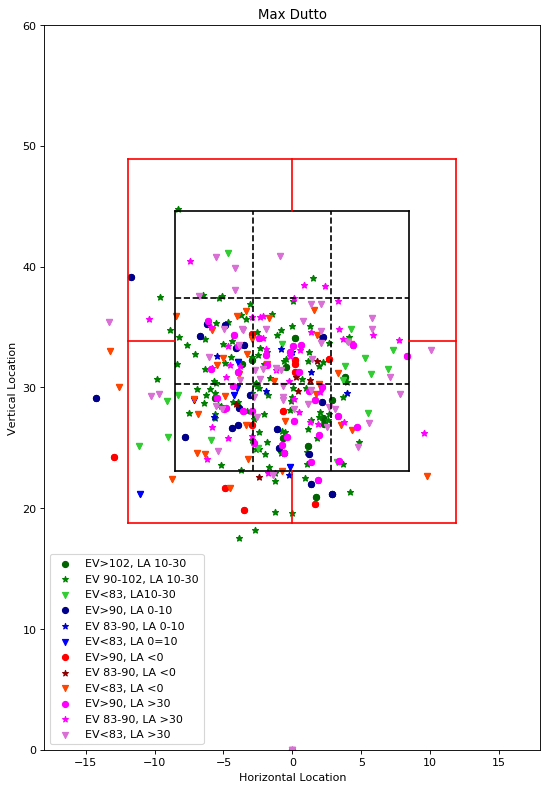

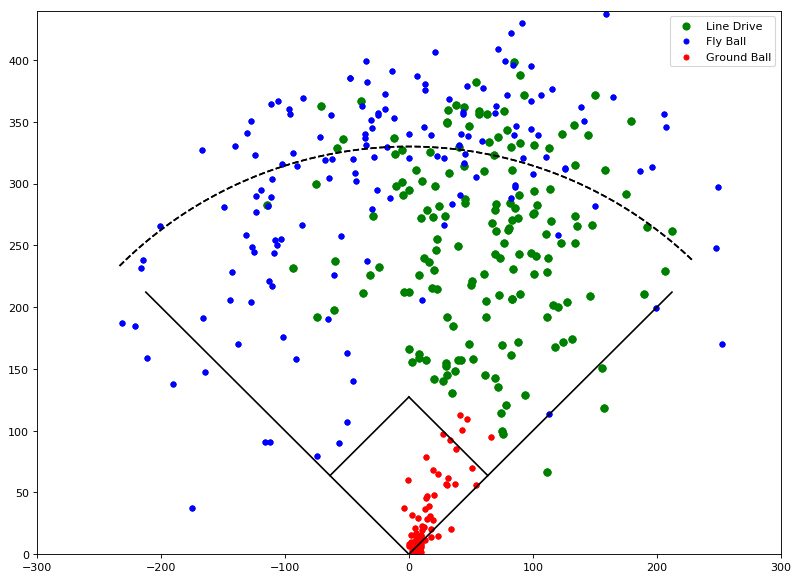

,Fly Balls,Ground Balls,Line Drive,AvgExitVelo,Max Exit Velo,Avg Launch Angle,BarrelEvents,Barrel/BBE%
Zone 1,1.00,0.00,0.00,85.2,85.2,23.00,0,0.00
Zone 2,0.80,0.20,0.00,85.9,91.6,36.70,2,10.00
Zone 3,0.58,0.42,0.00,84.5,98.9,35.17,6,25.00
Zone 4,0.50,0.12,0.38,82.3,102.0,24.33,2,4.17
Zone 5,0.38,0.23,0.39,87.3,103.2,23.79,28,19.72
Zone 6,0.36,0.19,0.45,88.8,102.6,20.55,30,20.27
Zone 7,0.56,0.17,0.28,83.1,99.6,25.50,4,11.11
Zone 8,0.40,0.10,0.49,90.9,104.3,24.10,52,33.77
Zone 9,0.32,0.25,0.43,88.3,102.4,16.58,26,21.67
Overall,0.39,0.18,0.42,87.6,104.3,22.04,166,21.50


In [377]:
hstats  = HitterSummary(hx2, 'Max Dutto', 44,55, 60, 90)

hstats

In [42]:
hstats

,Fly Balls,Ground Balls,Line Drive,AvgExitVelo,Max Exit Velo,Avg Launch Angle,BarrelEvents,Barrel/BBE%
Zone 1,0.60,0.20,0.20,83.8,99.1,28.80,1,20.00
Zone 2,0.20,0.20,0.60,77.3,97.0,20.40,0,0.00
Zone 3,0.75,0.25,0.00,77.2,98.4,31.75,0,0.00
Zone 4,0.57,0.13,0.30,84.2,102.9,26.22,2,8.70
Zone 5,0.56,0.26,0.19,81.2,102.4,25.30,2,7.41
Zone 6,0.70,0.10,0.20,81.1,99.3,40.30,2,10.00
Zone 7,0.28,0.56,0.15,76.6,96.9,6.21,2,5.13
Zone 8,0.33,0.43,0.24,83.1,101.8,17.39,5,9.26
Zone 9,0.57,0.07,0.36,87.0,102.4,34.07,4,28.57
Overall,0.43,0.31,0.25,81.3,102.9,20.77,19,8.96
